In [1]:
import pandas as pd

In [2]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("TensorFlow can access the GPU.")
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    print("TensorFlow Devices: ", tf.config.list_physical_devices())
else:
    print("TensorFlow cannot access the GPU. Please check your system configuration.")


TensorFlow can access the GPU.
Num GPUs Available:  1
TensorFlow Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import tensorflow as tf
print(tf.__version__)


2.10.1


### If you are using colab, you can import google drive to save model checkpoints in a folder
from google.colab import drive
drive.mount('/content/drive')

In [4]:
df = pd.read_csv("GME.csv")

In [5]:
df.shape

(251, 7)

In [6]:
df.tail(10)

,Date,Open,High,Low,Close,Adj Close,Volume
241,2021-12-16,38.232498,38.610001,35.532501,36.147499,36.147499,8659200
242,2021-12-17,35.937500,39.642502,34.832500,38.910000,38.910000,17226800
243,2021-12-20,38.297501,39.919998,37.424999,39.285000,39.285000,7314400
244,2021-12-21,39.264999,40.062500,38.785000,39.529999,39.529999,5720800
245,2021-12-22,39.582500,39.787498,38.029999,38.500000,38.500000,4188800
246,2021-12-23,38.500000,38.750000,36.505001,38.035000,38.035000,4222000
247,2021-12-27,38.000000,38.154999,35.000000,37.077499,37.077499,6454400
248,2021-12-28,36.875000,39.352501,36.602501,36.615002,36.615002,5324400
249,2021-12-29,36.962502,38.872501,35.535000,38.482498,38.482498,8149600
250,2021-12-30,37.750000,40.000000,37.500000,38.832500,38.832500,6247600


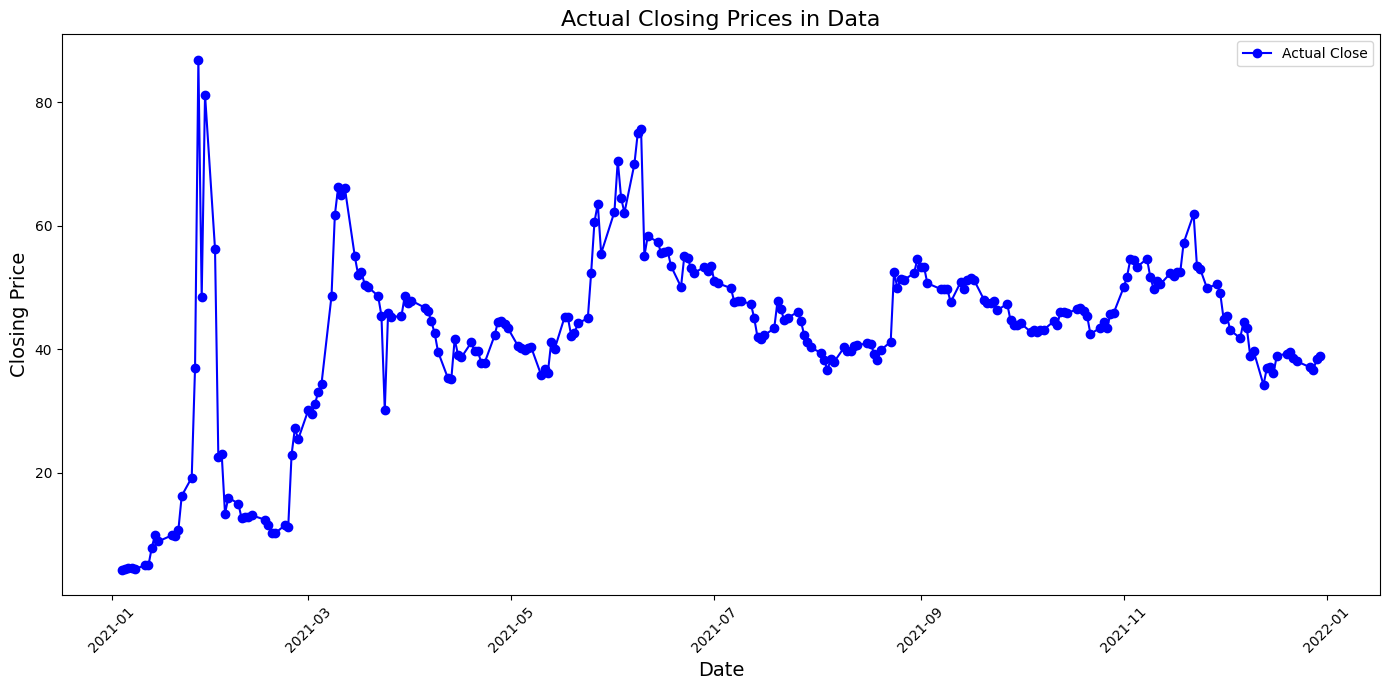

In [7]:
import matplotlib.pyplot as plt


# Ensure the 'Date' column is in datetime format for proper plotting
df['Date'] = pd.to_datetime(df['Date'])

# Setting the plot size for better readability
plt.figure(figsize=(14, 7))

# Plotting the actual closing prices in the training period
plt.plot(df['Date'], df['Close'], label='Actual Close', color='blue', marker='o')

# Adding title and labels with font size adjustments
plt.title('Actual Closing Prices in Data', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)

# Rotating date labels for better visibility
plt.xticks(rotation=45)

# Adding a legend to distinguish the actual values
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [8]:
import numpy as np
import missingno as msno
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, BatchNormalization
from keras.regularizers import l2
from keras import backend as K
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from datetime import datetime, timedelta

In [9]:
# Convert 'Date' to datetime and sort the DataFrame just in case
df['Date'] = pd.to_datetime(df['Date']) # This line converts the 'Date' column of the DataFrame df to datetime objects.
df.sort_values('Date', inplace=True)
#  The .values attribute returns the data as a NumPy array. The .reshape(-1, 1) function changes
#  the shape of this array to ensure it has two dimensions, with one column and as many rows as necessary.
close_prices = df['Close'].values.reshape(-1, 1)
# Scale the data -> you can use any appropriate scaling methodology
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close_prices = scaler.fit_transform(close_prices)

In [10]:
scaled_close_prices.shape

(251, 1)

In [11]:
# Function to create sequences
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [12]:
SEQUENCE_LENGTH = 10  # This can be adjusted
X, y = create_sequences(scaled_close_prices, SEQUENCE_LENGTH)

In [13]:
print(X)

print(y)

[[[0.00000000e+00]
  [3.63350079e-04]
  [3.36098823e-03]
  ...
  [4.28450301e-02]
  [6.86126066e-02]
  [5.52594912e-02]]

 [[3.63350079e-04]
  [3.36098823e-03]
  [2.51317138e-03]
  ...
  [6.86126066e-02]
  [5.52594912e-02]
  [6.69472521e-02]]

 [[3.36098823e-03]
  [2.51317138e-03]
  [1.33228362e-03]
  ...
  [5.52594912e-02]
  [6.69472521e-02]
  [6.62205519e-02]]

 ...

 [[3.62229762e-01]
  [3.94961548e-01]
  [3.97686649e-01]
  ...
  [4.14067694e-01]
  [4.08435768e-01]
  [3.96838833e-01]]

 [[3.94961548e-01]
  [3.97686649e-01]
  [3.85574980e-01]
  ...
  [4.08435768e-01]
  [3.96838833e-01]
  [3.91237222e-01]]

 [[3.97686649e-01]
  [3.85574980e-01]
  [4.19033479e-01]
  ...
  [3.96838833e-01]
  [3.91237222e-01]
  [4.13855716e-01]]]
[[0.06694725]
 [0.06622055]
 [0.07805971]
 [0.14461334]
 [0.1802822 ]
 [0.39583962]
 [1.        ]
 [0.53397324]
 [0.93184156]
 [0.62904982]
 [0.22028099]
 [0.22757828]
 [0.109762  ]
 [0.14085871]
 [0.12944347]
 [0.10010295]
 [0.10279779]
 [0.102495  ]
 [0.106431

In [14]:
print(X.shape)
print(y.shape)

(241, 10, 1)
(241, 1)


In [15]:
# Split the data into training and test sets (train on data until May 31st)
TRAIN_END_DATE = '2021-05-31'
TEST_END_DATE = '2021-08-31'

# Find the index corresponding to the end of May 2021
train_indices = df[df['Date'] <= TRAIN_END_DATE].index

# Find the index corresponding to the end of August 2021
test_indices = df[(df['Date'] > pd.to_datetime(TRAIN_END_DATE)) & (df['Date'] <= pd.to_datetime(TEST_END_DATE))].index

X_train, y_train = X[:train_indices[-1]-SEQUENCE_LENGTH], y[:train_indices[-1]-SEQUENCE_LENGTH]
X_test, y_test = X[train_indices[-1]+1-SEQUENCE_LENGTH:test_indices[-1]+1-SEQUENCE_LENGTH], y[train_indices[-1]+1-SEQUENCE_LENGTH:test_indices[-1]+1-SEQUENCE_LENGTH]

In [16]:
print(X_train.shape, y_train.shape)

(91, 10, 1) (91, 1)


In [17]:
print(X_test.shape, y_test.shape)

(65, 10, 1) (65, 1)


In [18]:
print(y_test)

[[0.70178041]
 [0.80236779]
 [0.7295161 ]
 [0.69978197]
 [0.79561558]
 [0.85614362]
 [0.86389508]
 [0.61509113]
 [0.65430264]
 [0.64249379]
 [0.62148003]
 [0.62290315]
 [0.62478045]
 [0.59519773]
 [0.55447221]
 [0.61512138]
 [0.6119118 ]
 [0.59062554]
 [0.58214737]
 [0.5934718 ]
 [0.58629564]
 [0.59616664]
 [0.56655361]
 [0.5619209 ]
 [0.5520196 ]
 [0.52507116]
 [0.52725126]
 [0.52679704]
 [0.52080178]
 [0.49297521]
 [0.45530792]
 [0.45288562]
 [0.45960755]
 [0.47308181]
 [0.52664564]
 [0.51038573]
 [0.48931146]
 [0.49388359]
 [0.50472355]
 [0.48837276]
 [0.45984979]
 [0.44695088]
 [0.43562645]
 [0.42511957]
 [0.4102828 ]
 [0.3922667 ]
 [0.41237207]
 [0.40731545]
 [0.43565676]
 [0.42935869]
 [0.42854114]
 [0.43935083]
 [0.43986556]
 [0.44413489]
 [0.44298432]
 [0.42330285]
 [0.41073696]
 [0.43011567]
 [0.44704171]
 [0.58450914]
 [0.5522921 ]
 [0.56915762]
 [0.56834007]
 [0.58120872]
 [0.60858112]]



The model described is a neural network architecture using Long Short-Term Memory (LSTM) layers, commonly employed for sequence prediction problems such as time series forecasting. Here's a breakdown of each component of the model:

1. LSTM Layer with return_sequences=True
LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)):
This is the first layer in the model and an LSTM layer with 50 units. LSTM units are a type of recurrent neural network (RNN) cell that are effective in capturing long-term dependencies in sequence data.
return_sequences=True indicates that this layer returns the full sequence of outputs for each sample. This is necessary when stacking LSTM layers so that the subsequent LSTM layer can receive sequences of data as input.
input_shape=(X_train.shape[1], 1) specifies the shape of the input data. In this context, X_train.shape[1] refers to the sequence length (number of time steps), and 1 refers to the number of features per time step. This model is configured to work with a single feature per time step, typical for univariate time series forecasting (e.g., predicting a stock price based on past values of the stock price alone).


2. LSTM Layer with return_sequences=False
LSTM(50, return_sequences=False):
This is the second LSTM layer in the model, also with 50 units.
return_sequences=False means this layer only returns the output for the last time step in the input sequence. This is used when the subsequent layer expects a single vector per sample rather than a sequence of vectors. Since the next layer is a dense layer (fully connected layer), only the final output of the LSTM is needed.
This layer serves to further process the information extracted by the first LSTM layer, focusing on extracting features that will be useful for the final prediction.


3. Dense Layer
Dense(1):
This is a fully connected layer that follows the LSTM layers. It has a single unit.
The purpose of this layer is to output a single value, which is the predicted value for the next time step in the sequence. For example, in stock price prediction, this would be the predicted stock price for the next day.
Since this model is likely intended for regression (predicting a continuous value), there's no activation function specified, implying a linear activation is used by default. This allows the model to output values in the range of the real numbers.

In [19]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [20]:
# Define the LSTM model
model = Sequential([
    LSTM(50, activation = 'relu', return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, activation = 'relu', return_sequences=True),
    LSTM(50, activation = 'relu', return_sequences=False),
    Dense(1)
])

# Optimizer
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error' , metrics=['mean_squared_error', rmse, 'mean_absolute_error', 'mean_absolute_percentage_error'])

# Train the model
model.fit(X_train, y_train, epochs=500, batch_size=128, verbose = 1)

Epoch 1/500


1/1 [==============================] - 6s 6s/step - loss: 0.2068 - mean_squared_error: 0.2068 - rmse: 0.4547 - mean_absolute_error: 0.4092 - mean_absolute_percentage_error: 100.8747
Epoch 2/500
1/1 [==============================] - 0s 124ms/step - loss: 0.1991 - mean_squared_error: 0.1991 - rmse: 0.4462 - mean_absolute_error: 0.4001 - mean_absolute_percentage_error: 97.6461
Epoch 3/500
1/1 [==============================] - 0s 115ms/step - loss: 0.1932 - mean_squared_error: 0.1932 - rmse: 0.4395 - mean_absolute_error: 0.3928 - mean_absolute_percentage_error: 94.9775
Epoch 4/500
1/1 [==============================] - 0s 107ms/step - loss: 0.1871 - mean_squared_error: 0.1871 - rmse: 0.4326 - mean_absolute_error: 0.3852 - mean_absolute_percentage_error: 92.1798
Epoch 5/500
1/1 [==============================] - 0s 112ms/step - loss: 0.1810 - mean_squared_error: 0.1810 - rmse: 0.4255 - mean_absolute_error: 0.3773 - mean_absolute_percentage_error: 89.2717
Epoch 6/500
1/1 [=================

In [21]:
business_days = pd.date_range(start=pd.to_datetime(TRAIN_END_DATE) + timedelta(days=1),
                              periods=66, freq='B')

In [22]:
business_days

DatetimeIndex(['2021-06-01', '2021-06-02', '2021-06-03', '2021-06-04',
               '2021-06-07', '2021-06-08', '2021-06-09', '2021-06-10',
               '2021-06-11', '2021-06-14', '2021-06-15', '2021-06-16',
               '2021-06-17', '2021-06-18', '2021-06-21', '2021-06-22',
               '2021-06-23', '2021-06-24', '2021-06-25', '2021-06-28',
               '2021-06-29', '2021-06-30', '2021-07-01', '2021-07-02',
               '2021-07-05', '2021-07-06', '2021-07-07', '2021-07-08',
               '2021-07-09', '2021-07-12', '2021-07-13', '2021-07-14',
               '2021-07-15', '2021-07-16', '2021-07-19', '2021-07-20',
               '2021-07-21', '2021-07-22', '2021-07-23', '2021-07-26',
               '2021-07-27', '2021-07-28', '2021-07-29', '2021-07-30',
               '2021-08-02', '2021-08-03', '2021-08-04', '2021-08-05',
               '2021-08-06', '2021-08-09', '2021-08-10', '2021-08-11',
               '2021-08-12', '2021-08-13', '2021-08-16', '2021-08-17',
      

In [23]:
# Get the last sequence from the training data
last_sequence = X_train[-1].reshape((1, SEQUENCE_LENGTH, 1))

In [24]:
# Create a list to hold predictions
predictions = []

# Predict future prices
for i in range(len(business_days)):
    # Get the prediction (scaled value)
    current_prediction = model.predict(last_sequence)[0]

    # Append the prediction
    predictions.append(current_prediction)

    # Check if there's an actual next value available in y_test
    if i < len(y_test):
        # Update 'last_sequence' with the actual next value from y_test
        actual_next_value = y_test[i]
        last_sequence = np.roll(last_sequence, -1, axis=1)
        last_sequence[0, -1, 0] = actual_next_value
    else:
        # If no actual next value is available, use the predicted value (for predictions beyond y_test)
        last_sequence = np.roll(last_sequence, -1, axis=1)
        last_sequence[0, -1, 0] = current_prediction

# Inverse transform the predictions to get actual values
predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Create a DataFrame with the predicted stock prices and dates
predictions_df = pd.DataFrame({
    'Date': business_days,
    'Predicted_Close': predicted_prices.flatten()
})

# Show the prediction results
print(predictions_df)

1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 47ms/step
         Date  Predicted_Close
0  2021-06-01        59.010445
1  2021-06-02        59.543983
2  2021-06-03        61.573044
3  2021-06-04        58.990559
4  2021-06-07        57.066444
..        ...              ...
61 2021-08-25        53.516556
62 2021-08-26        51.871582
63 2021-08-27        49.200794
64 2021-08-30        51.207821
65 2021-08-31        54.112732

[66 rows x 2 columns]


In [25]:
# Continue from the previous predictions_df creation code

# Ensure the 'Date' columns in both DataFrames are in the same format
df['Date'] = pd.to_datetime(df['Date'])
predictions_df['Date'] = pd.to_datetime(predictions_df['Date'])

# Merge the predictions with the actual closing prices from 'df'
predictions_with_actuals_df = predictions_df.merge(df[['Date', 'Close']], on='Date', how='left')

# Rename columns for clarity
predictions_with_actuals_df.rename(columns={'Close': 'Actual_Close'}, inplace=True)

# Show the DataFrame with predictions and actual closing prices
print(predictions_with_actuals_df)

         Date  Predicted_Close  Actual_Close
0  2021-06-01        59.010445     62.255001
1  2021-06-02        59.543983     70.559998
2  2021-06-03        61.573044     64.544998
3  2021-06-04        58.990559     62.090000
4  2021-06-07        57.066444     70.002502
..        ...              ...           ...
61 2021-08-25        53.516556     49.912498
62 2021-08-26        51.871582     51.305000
63 2021-08-27        49.200794     51.237499
64 2021-08-30        51.207821     52.299999
65 2021-08-31        54.112732     54.560001

[66 rows x 3 columns]


In [26]:
print(predictions_with_actuals_df["Actual_Close"].isnull().sum())
print(predictions_with_actuals_df["Predicted_Close"].isnull().sum())

predictions_with_actuals_df.dropna(subset=["Actual_Close", "Predicted_Close"], inplace=True)

1
0


In [27]:
mse = mean_squared_error(predictions_with_actuals_df["Actual_Close"], predictions_with_actuals_df["Predicted_Close"])
rmse = np.sqrt(mse)
mae = mean_absolute_error(predictions_with_actuals_df["Actual_Close"], predictions_with_actuals_df["Predicted_Close"])

print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ", rmse)
print("Mean Absolute Error: ", mae)

Mean Squared Error:  18.646688259132834
Root Mean Squared Error:  4.3181811285693925
Mean Absolute Error:  2.800768384367488


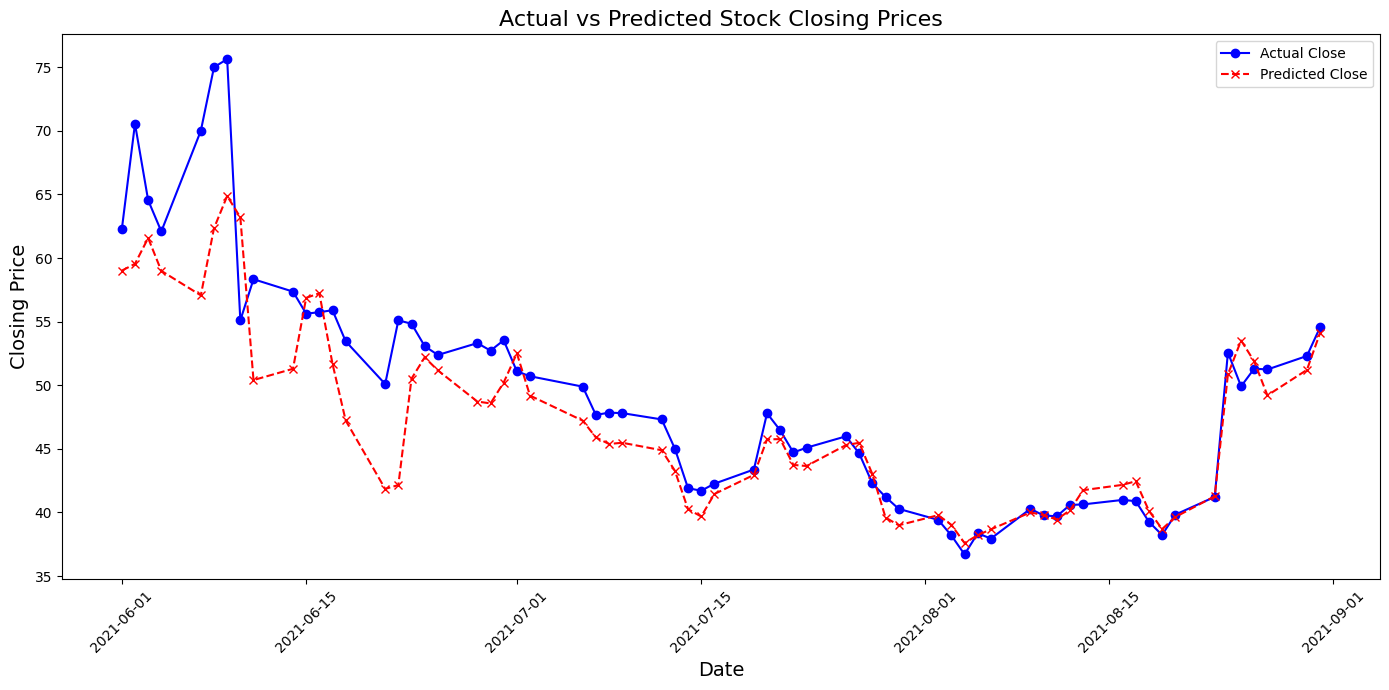

In [28]:


# Ensure the 'Date' column is in datetime format for proper plotting
predictions_with_actuals_df['Date'] = pd.to_datetime(predictions_with_actuals_df['Date'])

# Setting the plot size for better readability
plt.figure(figsize=(14, 7))

# Plotting the actual closing prices
plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Actual_Close'], label='Actual Close', color='blue', marker='o')

# Plotting the predicted closing prices
plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Predicted_Close'], label='Predicted Close', color='red', linestyle='--', marker='x')

# Adding title and labels with font size adjustments
plt.title('Actual vs Predicted Stock Closing Prices', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)

# Rotating date labels for better visibility
plt.xticks(rotation=45)

# Adding a legend to distinguish between actual and predicted values
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

Incorporating the sentiment data to train LSTM.

In [29]:
sentiment_df = pd.read_csv('rGME_dataset_features.csv')

c:\Users\ac253\anaconda3\envs\NLXIndAssign\lib\site-packages\IPython\core\interactiveshell.py:3552: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [30]:
sentiment_df.head(20)

,Unnamed: 0,id,title,url,score,author,num_comments,date,flair,compound,...,_poss,_intj,_appos,_npadvmod,_predet,_case,_expl,_oprd,_dative,_nmod
0,0,kqfajb,You NEED to see this about GME 🚀🚀🚀🚀🚀🚀,https://www.reddit.com/r/GME/comments/kqfajb/y...,1.0,TitsDownOnly,9.0,2021-01-04,NaN,0.9872,...,0,0,6,0,0,0,0,0,0,0
1,1,kqjh2t,Short Squeeze Incoming 🚀🚀🚀🚀🚀🚀🚀,/r/wallstreetbets/comments/kqcwdo/gamestops_gr...,1.0,zoomermoney,1.0,2021-01-04,NaN,0.9906,...,0,0,3,0,0,0,0,0,0,0
2,2,kqvp7l,THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...,https://www.reddit.com/r/GME/comments/kqvp7l/t...,1.0,TitsDownOnly,6.0,2021-01-05,NaN,0.5319,...,0,0,0,0,0,0,0,0,0,0
3,3,krcwch,You already know what we must do brothers and ...,/r/wallstreetbets/comments/kr98ym/gme_gang_we_...,1.0,dontforgettolive,4.0,2021-01-05,NaN,-0.2960,...,1,0,0,0,0,0,0,0,0,0
4,4,krnthg,ICR conference (11th Jan),https://www.reddit.com/r/GME/comments/krnthg/i...,1.0,nicky94,10.0,2021-01-06,NaN,0.0000,...,0,0,0,1,0,0,0,0,0,0
5,5,kryizd,Hey guys! We have a free discord channel that'...,https://www.reddit.com/r/GME/comments/kryizd/h...,1.0,thehelper900,15.0,2021-01-06,NaN,0.7777,...,0,1,0,0,0,0,0,0,0,0
6,6,kuo3w1,"GME is FINALLY going to the moon, this technic...",https://www.reddit.com/r/GME/comments/kuo3w1/g...,1.0,TitsDownOnly,16.0,2021-01-10,NaN,0.9667,...,0,0,2,0,0,0,0,0,0,0
7,7,kv1t51,Ryan Cohen appointed to board!!!!?,https://news.gamestop.com/news-releases/news-r...,1.0,nicky94,6.0,2021-01-11,NaN,0.0000,...,0,0,0,0,0,0,0,0,0,0
8,8,kv1w9e,"Holly f*ck, our GME rollercoaster will break o...",https://www.reddit.com/r/GME/comments/kv1w9e/h...,1.0,username-__-taken,20.0,2021-01-11,NaN,0.0000,...,1,0,0,0,0,0,0,0,0,0
9,9,kv3vrm,BUCKLE YOUR SEATBELTS OR YOURE GONNA FALL OFF ...,https://i.redd.it/t8e6nqnxspa61.png,1.0,jonastirona,1.0,2021-01-11,NaN,0.9517,...,1,0,1,0,0,0,0,0,0,0


<AxesSubplot:>

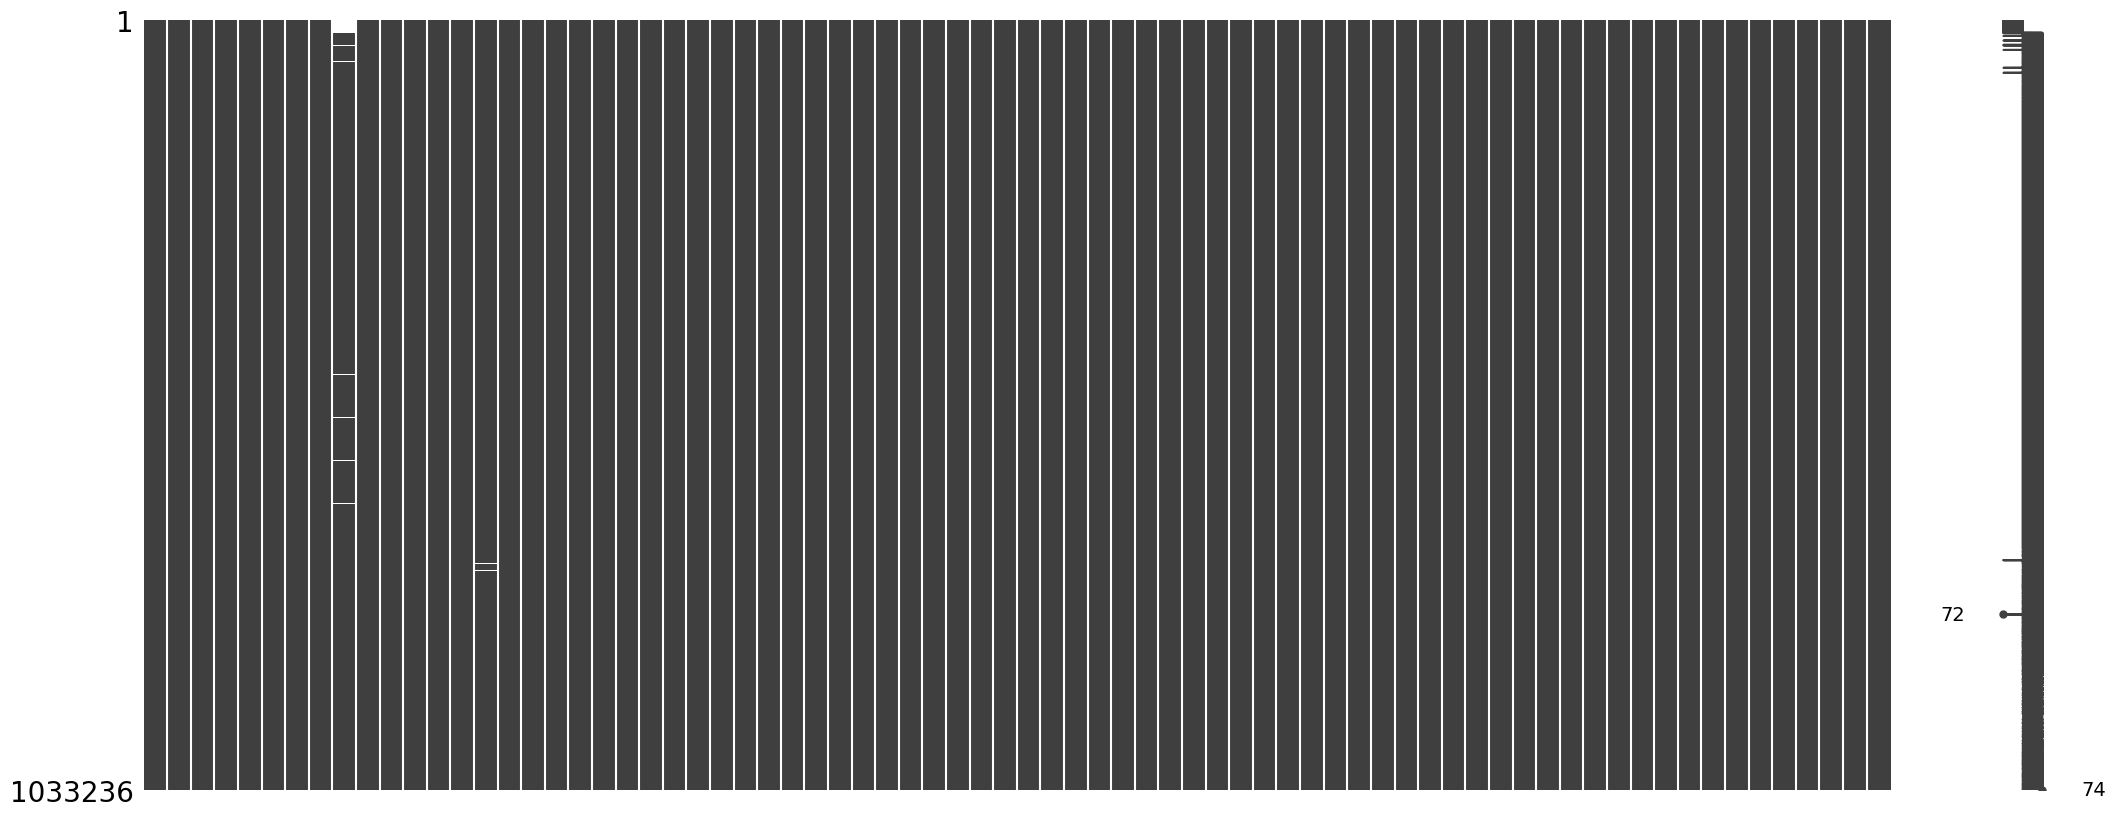

In [31]:
msno.matrix(sentiment_df)

<AxesSubplot:>

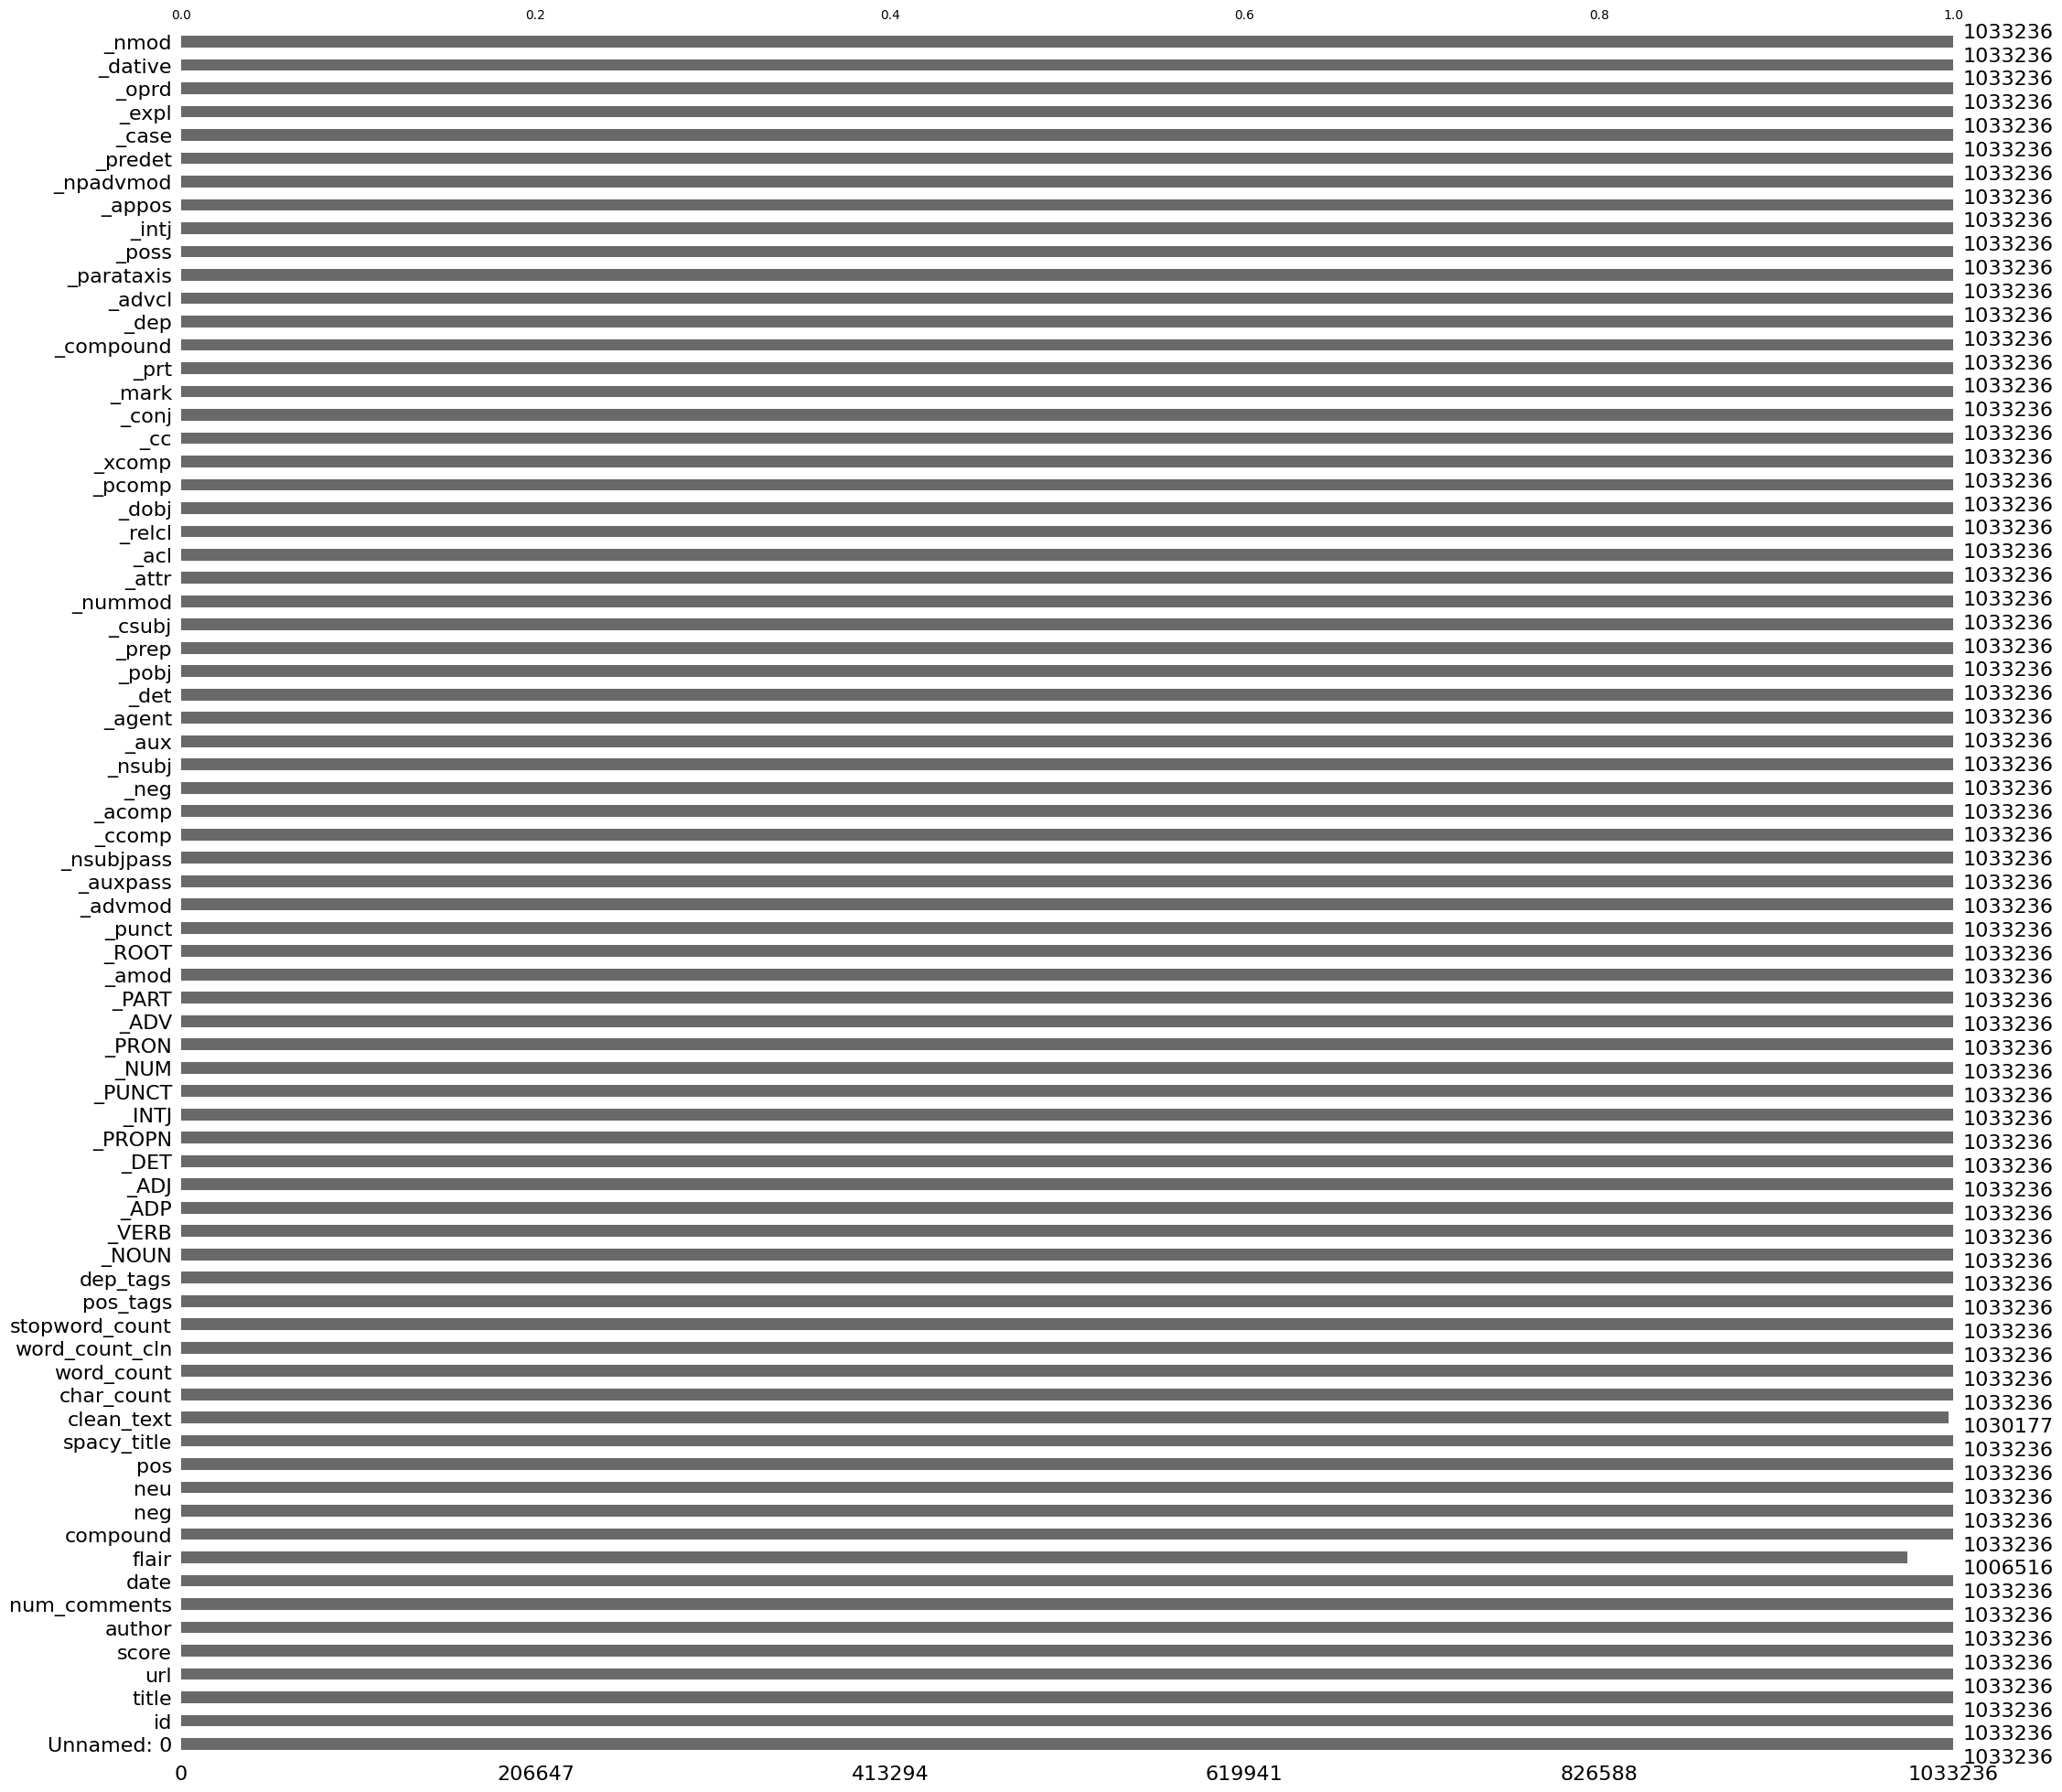

In [32]:
msno.bar(sentiment_df)

In [33]:
sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1033236 entries, 0 to 1033235
Data columns (total 74 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   Unnamed: 0      1033236 non-null  int64  
 1   id              1033236 non-null  object 
 2   title           1033236 non-null  object 
 3   url             1033236 non-null  object 
 4   score           1033236 non-null  float64
 5   author          1033236 non-null  object 
 6   num_comments    1033236 non-null  float64
 7   date            1033236 non-null  object 
 8   flair           1006516 non-null  object 
 9   compound        1033236 non-null  float64
 10  neg             1033236 non-null  float64
 11  neu             1033236 non-null  float64
 12  pos             1033236 non-null  float64
 13  spacy_title     1033236 non-null  object 
 14  clean_text      1030177 non-null  object 
 15  char_count      1033236 non-null  int64  
 16  word_count      1033236 non-null  in

In [34]:
sentiment_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1033236.0,516617.500000,298269.685706,0.0000,258308.75,516617.5,774926.2500,1033235.0
score,1033236.0,3.486193,93.732797,0.0000,1.00,1.0,1.0000,59578.0
num_comments,1033236.0,12.269418,107.590595,0.0000,1.00,5.0,10.0000,36189.0
compound,1033236.0,0.152268,0.419748,-0.9963,0.00,0.0,0.4574,1.0
neg,1033236.0,0.067381,0.147753,0.0000,0.00,0.0,0.0590,1.0
...,...,...,...,...,...,...,...,...
_case,1033236.0,0.039243,0.200817,0.0000,0.00,0.0,0.0000,20.0
_expl,1033236.0,0.006203,0.081620,0.0000,0.00,0.0,0.0000,3.0
_oprd,1033236.0,0.004941,0.081326,0.0000,0.00,0.0,0.0000,11.0
_dative,1033236.0,0.014138,0.121439,0.0000,0.00,0.0,0.0000,4.0


In [35]:
sentiment_df.shape

(1033236, 74)

In [36]:
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

In [37]:
sentiment_df_small = sentiment_df[["id", "date", "score", "num_comments", "compound", "neg", "neu", "pos", "word_count_cln"]]
sentiment_df_small.head(20)

,id,date,score,num_comments,compound,neg,neu,pos,word_count_cln
0,kqfajb,2021-01-04,1.0,9.0,0.9872,0.000,0.189,0.811,8
1,kqjh2t,2021-01-04,1.0,1.0,0.9906,0.000,0.079,0.921,10
2,kqvp7l,2021-01-05,1.0,6.0,0.5319,0.000,0.744,0.256,6
3,krcwch,2021-01-05,1.0,4.0,-0.2960,0.115,0.885,0.000,5
4,krnthg,2021-01-06,1.0,10.0,0.0000,0.000,1.000,0.000,4
5,kryizd,2021-01-06,1.0,15.0,0.7777,0.107,0.516,0.377,9
6,kuo3w1,2021-01-10,1.0,16.0,0.9667,0.000,0.392,0.608,11
7,kv1t51,2021-01-11,1.0,6.0,0.0000,0.000,1.000,0.000,4
8,kv1w9e,2021-01-11,1.0,20.0,0.0000,0.000,1.000,0.000,6
9,kv3vrm,2021-01-11,1.0,1.0,0.9517,0.000,0.423,0.577,10


In [38]:
sentiment_df_small.drop_duplicates(keep='first', inplace=True)

c:\Users\ac253\anaconda3\envs\NLXIndAssign\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [39]:
COMMENT_THRESHOLD = 20
SCORE_THRESHOLD = 10


sentiment_df_small_filtered = sentiment_df_small[~((sentiment_df_small['num_comments'] < COMMENT_THRESHOLD) & (sentiment_df_small['score'] < SCORE_THRESHOLD))]

In [40]:
sentiment_df_small_filtered.corr()

,score,num_comments,compound,neg,neu,pos,word_count_cln
score,1.000000,0.111392,0.011317,-0.001022,-0.003050,0.004087,0.036296
num_comments,0.111392,1.000000,-0.015103,-0.004770,0.023305,-0.022605,0.013539
compound,0.011317,-0.015103,1.000000,-0.545647,-0.334265,0.742323,0.249631
neg,-0.001022,-0.004770,-0.545647,1.000000,-0.459173,-0.171917,-0.018922
neu,-0.003050,0.023305,-0.334265,-0.459173,1.000000,-0.796181,-0.137241
pos,0.004087,-0.022605,0.742323,-0.171917,-0.796181,1.000000,0.165082
word_count_cln,0.036296,0.013539,0.249631,-0.018922,-0.137241,0.165082,1.000000


<AxesSubplot:>

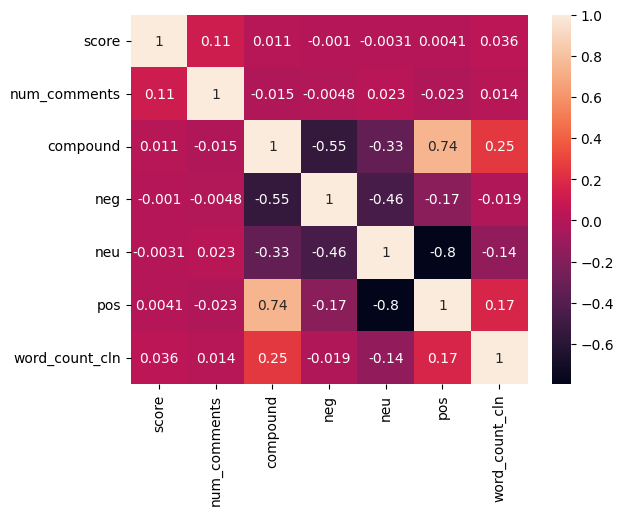

In [41]:
sns.heatmap(sentiment_df_small_filtered.corr(), annot=True)

In [42]:
sentiment_df_small_filtered.sort_values(by='date', ascending=True, inplace=True)

sentiment_df_small_filtered.head(20)

c:\Users\ac253\anaconda3\envs\NLXIndAssign\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,id,date,score,num_comments,compound,neg,neu,pos,word_count_cln
8,kv1w9e,2021-01-11,1.0,20.0,0.0000,0.000,1.000,0.000,6
17,kwjdpe,2021-01-13,3.0,21.0,0.0000,0.000,1.000,0.000,2
35,kxkkt4,2021-01-14,1.0,29.0,0.0000,0.000,1.000,0.000,2
50,kym7ae,2021-01-16,1.0,21.0,0.0000,0.000,1.000,0.000,3
51,kyodi5,2021-01-16,2.0,34.0,0.0000,0.000,1.000,0.000,6
54,kzf5mz,2021-01-17,1.0,27.0,0.2263,0.000,0.513,0.487,1
57,kzl3ne,2021-01-17,1.0,93.0,0.7698,0.082,0.617,0.301,11
75,l0lcji,2021-01-19,1.0,21.0,-0.2235,0.239,0.761,0.000,3
77,l0lnju,2021-01-19,2.0,20.0,0.3736,0.000,0.661,0.339,4
82,l17ic7,2021-01-20,1.0,99.0,0.3595,0.000,0.707,0.293,7


In [43]:
sentiment_df_small_filtered.describe().T

,count,mean,std,min,25%,50%,75%,max
score,42293.0,57.638333,459.860480,0.0000,1.000,2.000,20.0000,59578.0
num_comments,42293.0,71.889698,483.535857,0.0000,15.000,27.000,50.0000,36189.0
compound,42293.0,0.143395,0.433773,-0.9873,0.000,0.000,0.4574,1.0
neg,42293.0,0.067591,0.135754,0.0000,0.000,0.000,0.0860,1.0
neu,42293.0,0.791068,0.221022,0.0000,0.653,0.827,1.0000,1.0
pos,42293.0,0.141341,0.199313,0.0000,0.000,0.000,0.2390,1.0
word_count_cln,42293.0,7.262951,6.070378,0.0000,3.000,6.000,9.0000,141.0


In [44]:
#Calculate weighted sentiment scores using 'num_comments' as the weight
sentiment_df_small_filtered['weighted_compound'] = sentiment_df_small_filtered['compound'] * sentiment_df_small_filtered['num_comments']
sentiment_df_small_filtered['weighted_neg'] = sentiment_df_small_filtered['neg'] * sentiment_df_small_filtered['num_comments']
sentiment_df_small_filtered['weighted_neu'] = sentiment_df_small_filtered['neu'] * sentiment_df_small_filtered['num_comments']
sentiment_df_small_filtered['weighted_pos'] = sentiment_df_small_filtered['pos'] * sentiment_df_small_filtered['num_comments']

# Calculate weighted sentiment scores using 'score' as the weight
#filtered_df['weighted_compound_score'] = filtered_df['compound'] * filtered_df['score']
#filtered_df['weighted_neg_score'] = filtered_df['neg'] * filtered_df['score']
#filtered_df['weighted_neu_score'] = filtered_df['neu'] * filtered_df['score']
#filtered_df['weighted_pos_score'] = filtered_df['pos'] * filtered_df['score']

c:\Users\ac253\anaconda3\envs\NLXIndAssign\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\ac253\anaconda3\envs\NLXIndAssign\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\Users\ac253\anaconda3\envs\NLXIndAssign\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [45]:
sentiment_df_sorted_grouped = sentiment_df_small_filtered.groupby('date').agg({
    'weighted_compound': 'sum',
    'weighted_neg': 'sum',
    'weighted_neu': 'sum',
    'weighted_pos': 'sum',
    'num_comments': 'sum',
    'score': 'sum'
}).reset_index()

# Calculate the weighted average sentiment for each day
sentiment_df_sorted_grouped['avg_weighted_compound'] = sentiment_df_sorted_grouped['weighted_compound'] / sentiment_df_sorted_grouped['num_comments']
sentiment_df_sorted_grouped['avg_weighted_neg'] = sentiment_df_sorted_grouped['weighted_neg'] / sentiment_df_sorted_grouped['num_comments']
sentiment_df_sorted_grouped['avg_weighted_neu'] = sentiment_df_sorted_grouped['weighted_neu'] / sentiment_df_sorted_grouped['num_comments']
sentiment_df_sorted_grouped['avg_weighted_pos'] = sentiment_df_sorted_grouped['weighted_pos'] / sentiment_df_sorted_grouped['num_comments']

sentiment_df_sorted_grouped.replace([np.inf, -np.inf], np.nan, inplace=True)
sentiment_df_sorted_grouped.fillna(0, inplace=True)

In [46]:
sentiment_df_sorted_grouped.drop(['weighted_compound', 'weighted_neg', 'weighted_neu', 'weighted_pos'], axis=1, inplace=True)

In [47]:
sentiment_df_sorted_grouped.head(321)

,date,num_comments,score,avg_weighted_compound,avg_weighted_neg,avg_weighted_neu,avg_weighted_pos
0,2021-01-11,20.0,1.0,0.000000,0.000000,1.000000,0.000000
1,2021-01-13,21.0,3.0,0.000000,0.000000,1.000000,0.000000
2,2021-01-14,29.0,1.0,0.000000,0.000000,1.000000,0.000000
3,2021-01-16,55.0,3.0,0.000000,0.000000,1.000000,0.000000
4,2021-01-17,120.0,2.0,0.647513,0.063550,0.593600,0.342850
...,...,...,...,...,...,...,...
310,2021-12-07,6525.0,94232.0,0.273822,0.032083,0.820205,0.147717
311,2021-12-08,8014.0,61115.0,0.151607,0.064720,0.796248,0.139005
312,2021-12-09,3079.0,223.0,0.055083,0.077695,0.823520,0.098805
313,2021-12-10,4042.0,38.0,0.036775,0.062924,0.828005,0.109101


In [48]:
df_sentiment = sentiment_df_sorted_grouped.copy()

In [49]:
print(df_sentiment.describe().T)

print(df_sentiment.info())

                       count         mean           std       min  \
num_comments           315.0  9652.161905  18148.196675  20.00000   
score                  315.0  7738.723810  39802.678301   1.00000   
avg_weighted_compound  315.0     0.116886      0.111505  -0.30384   
avg_weighted_neg       315.0     0.057419      0.030174   0.00000   
avg_weighted_neu       315.0     0.825728      0.056186   0.59360   
avg_weighted_pos       315.0     0.116855      0.050353   0.00000   

                               25%          50%          75%            max  
num_comments           2930.500000  4139.000000  7258.500000  126073.000000  
score                    38.000000    48.000000   118.000000  326417.000000  
avg_weighted_compound     0.044810     0.107659     0.176825       0.647513  
avg_weighted_neg          0.036539     0.053241     0.074756       0.172550  
avg_weighted_neu          0.793531     0.831066     0.857269       1.000000  
avg_weighted_pos          0.088418     0.109541 

In [50]:
combined_df = pd.merge(df, df_sentiment, left_on='Date', right_on='date', how='left')
combined_df.drop(columns=['date'], inplace=True) # Drop the duplicate 'date' column
combined_df.fillna(method='ffill', inplace=True) # Forward fill any missing values

In [51]:
combined_df.dropna(inplace=True)
combined_df.reset_index(drop=True, inplace=True)
combined_df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)

combined_df['Closing Price'] = combined_df['Close']
combined_df.drop(columns=['Close'], inplace=True)

In [52]:
combined_df.head(20)

,Date,num_comments,score,avg_weighted_compound,avg_weighted_neg,avg_weighted_neu,avg_weighted_pos,Closing Price
0,2021-01-11,20.0,1.0,0.000000,0.000000,1.000000,0.000000,4.985000
1,2021-01-12,20.0,1.0,0.000000,0.000000,1.000000,0.000000,4.987500
2,2021-01-13,21.0,3.0,0.000000,0.000000,1.000000,0.000000,7.850000
3,2021-01-14,29.0,1.0,0.000000,0.000000,1.000000,0.000000,9.977500
4,2021-01-15,29.0,1.0,0.000000,0.000000,1.000000,0.000000,8.875000
5,2021-01-19,41.0,3.0,0.067768,0.122415,0.712220,0.165366,9.840000
6,2021-01-20,154.0,2.0,0.381643,0.000000,0.603429,0.396571,9.780000
7,2021-01-21,320.0,5.0,0.019982,0.072337,0.903703,0.023831,10.757500
8,2021-01-22,1002.0,11.0,0.046663,0.000000,0.957446,0.042554,16.252501
9,2021-01-25,23.0,1.0,0.000000,0.000000,1.000000,0.000000,19.197500


In [53]:
print(combined_df.shape)

print(combined_df.info())

(246, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   246 non-null    datetime64[ns]
 1   num_comments           246 non-null    float64       
 2   score                  246 non-null    float64       
 3   avg_weighted_compound  246 non-null    float64       
 4   avg_weighted_neg       246 non-null    float64       
 5   avg_weighted_neu       246 non-null    float64       
 6   avg_weighted_pos       246 non-null    float64       
 7   Closing Price          246 non-null    float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 15.5 KB
None


In [54]:
combined_df['Date'] = pd.to_datetime(combined_df['Date'])

In [55]:
train_indices = combined_df[combined_df["Date"] <= TRAIN_END_DATE].index
test_indices = combined_df[(combined_df["Date"] > TRAIN_END_DATE) & (combined_df["Date"] <= TEST_END_DATE)].index

combined_train_df = combined_df[combined_df.index <= pd.to_datetime(TRAIN_END_DATE)]
combined_test_df = combined_df[(combined_df.index > pd.to_datetime(TRAIN_END_DATE)) & (combined_df.index <= pd.to_datetime(TEST_END_DATE))]

In [56]:
features = combined_df.drop(columns=['Date']) # Drop the 'Date' column
target = combined_df['Closing Price'] # Set the 'Closing Price' as the target variable

In [57]:
scaler_new = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_new.fit_transform(features)
scaled_target = scaler_new.fit_transform(target.values.reshape(-1, 1)).flatten()  # Flatten to make it a 1D array

In [58]:
def create_train_sequences(features, target, sequence_length):
    X, y = [], []
    for i in range(len(features) - sequence_length):
        seq = features[i:i+sequence_length]  # Include closing price in features
        X.append(seq)
        y.append(target[i + sequence_length])  # Target is the closing price at sequence_length ahead
    return np.array(X), np.array(y)

In [59]:
# Splitting the data
train_end = train_indices[-1] + 1  
test_end = test_indices[-1] + 1

# Creating training sequences
X_train, y_train = create_train_sequences(scaled_features[:train_end], scaled_target[:train_end], SEQUENCE_LENGTH)

# Creating testing sequences
# For X_test, we want to exclude the closing price
X_test, y_test = create_train_sequences(scaled_features[train_end:test_end], scaled_target[train_end:test_end], SEQUENCE_LENGTH)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [60]:
X_train.shape, y_train.shape

((87, 10, 7), (87, 1))

In [61]:
X_test.shape, y_test.shape

((55, 10, 7), (55, 1))

In [62]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

lstm_model = Sequential([
    LSTM(units=64, activation="relu", return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]),
         kernel_regularizer=l2(0.001)),
    Dropout(0.3),  
    BatchNormalization(),  
    
    
    LSTM(units=32, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.3),  
    BatchNormalization(),
    
    
    Dense(units=64, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    BatchNormalization(),

    
    Dense(units=1)
])

lstm_model = Sequential([
    LSTM(units=50, activation="relu", return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(units=50, activation="relu"),  # Note: return_sequences is False by default
    Dropout(0.2),
    Dense(units=100, activation="relu"),  # Additional Dense layer with 100 units
    Dropout(0.2),
    Dense(units=50, activation="relu"),  # Additional Dense layer with 50 units
    Dropout(0.2),
    Dense(units=1)  # Output layer predicting a single value
])

lstm_model_simplified = Sequential([
    LSTM(units=32, activation="relu", input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(units=1)
])

In [63]:
lstm_model = Sequential([
    LSTM(units=50, activation="relu", return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(units=50, activation="relu", return_sequences=True),  
    Dropout(0.2),
    Dense(units=100, activation="relu"), 
    Dropout(0.2),
    Dense(units=50, activation="sigmoid"),  
    Dropout(0.2),
    Dense(units=1)  
])

# Optimizer
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)


lstm_model.compile(optimizer=optimizer, loss='mean_squared_error' , metrics=['mean_squared_error', rmse, 'mean_absolute_error', 'mean_absolute_percentage_error'])

In [64]:
history = lstm_model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=32,
    verbose=1
)

Epoch 1/500
3/3 [==============================] - 4s 95ms/step - loss: 1.2496 - mean_squared_error: 1.2496 - rmse: 1.1149 - mean_absolute_error: 1.0447 - mean_absolute_percentage_error: 330.1769
Epoch 2/500
3/3 [==============================] - 0s 92ms/step - loss: 1.1227 - mean_squared_error: 1.1227 - rmse: 1.0543 - mean_absolute_error: 0.9876 - mean_absolute_percentage_error: 303.3459
Epoch 3/500
3/3 [==============================] - 0s 107ms/step - loss: 0.9167 - mean_squared_error: 0.9167 - rmse: 0.9399 - mean_absolute_error: 0.8763 - mean_absolute_percentage_error: 261.5468
Epoch 4/500
3/3 [==============================] - 0s 117ms/step - loss: 0.6905 - mean_squared_error: 0.6905 - rmse: 0.8259 - mean_absolute_error: 0.7430 - mean_absolute_percentage_error: 223.8874
Epoch 5/500
3/3 [==============================] - 0s 93ms/step - loss: 0.4926 - mean_squared_error: 0.4926 - rmse: 0.6866 - mean_absolute_error: 0.6031 - mean_absolute_percentage_error: 177.9195
Epoch 6/500
3/3 [=

3/3 [==============================] - 0s 94ms/step - loss: 0.1376 - mean_squared_error: 0.1376 - rmse: 0.3705 - mean_absolute_error: 0.2933 - mean_absolute_percentage_error: 117.3815
Epoch 29/500
3/3 [==============================] - 0s 80ms/step - loss: 0.1342 - mean_squared_error: 0.1342 - rmse: 0.3668 - mean_absolute_error: 0.2892 - mean_absolute_percentage_error: 114.1928
Epoch 30/500
3/3 [==============================] - 0s 96ms/step - loss: 0.1263 - mean_squared_error: 0.1263 - rmse: 0.3545 - mean_absolute_error: 0.2807 - mean_absolute_percentage_error: 107.7676
Epoch 31/500
3/3 [==============================] - 0s 102ms/step - loss: 0.1400 - mean_squared_error: 0.1400 - rmse: 0.3754 - mean_absolute_error: 0.2957 - mean_absolute_percentage_error: 114.3720
Epoch 32/500
3/3 [==============================] - 0s 87ms/step - loss: 0.1385 - mean_squared_error: 0.1385 - rmse: 0.3735 - mean_absolute_error: 0.2977 - mean_absolute_percentage_error: 121.1976
Epoch 33/500
3/3 [=========

In [65]:
business_days = pd.date_range(start=pd.to_datetime(TRAIN_END_DATE) + timedelta(days=1),
                              periods=66, freq='B')
business_days

DatetimeIndex(['2021-06-01', '2021-06-02', '2021-06-03', '2021-06-04',
               '2021-06-07', '2021-06-08', '2021-06-09', '2021-06-10',
               '2021-06-11', '2021-06-14', '2021-06-15', '2021-06-16',
               '2021-06-17', '2021-06-18', '2021-06-21', '2021-06-22',
               '2021-06-23', '2021-06-24', '2021-06-25', '2021-06-28',
               '2021-06-29', '2021-06-30', '2021-07-01', '2021-07-02',
               '2021-07-05', '2021-07-06', '2021-07-07', '2021-07-08',
               '2021-07-09', '2021-07-12', '2021-07-13', '2021-07-14',
               '2021-07-15', '2021-07-16', '2021-07-19', '2021-07-20',
               '2021-07-21', '2021-07-22', '2021-07-23', '2021-07-26',
               '2021-07-27', '2021-07-28', '2021-07-29', '2021-07-30',
               '2021-08-02', '2021-08-03', '2021-08-04', '2021-08-05',
               '2021-08-06', '2021-08-09', '2021-08-10', '2021-08-11',
               '2021-08-12', '2021-08-13', '2021-08-16', '2021-08-17',
      

In [66]:
# Initialize the starting sequence for prediction
current_sequence = X_train[-1]

# Initialize an empty list to store predicted prices
predicted_prices = []

# Predict future prices
for i in range(len(business_days)):

    if i < len(X_test):
        current_sequence = X_test[i]
    else:
        # Once beyond the range of X_test, you need to start using the last predicted values
        # since actual values are no longer available
        # Prepare the next sequence based on the last prediction
        next_sequence = np.roll(current_sequence, -1, axis=0)
        next_sequence[-1, -1] = predicted_close_scaled.flatten()[0]  # Update with last predicted close
        current_sequence = next_sequence

    # Reshape the current sequence to match the model's expected input shape and predict the next closing price
    predicted_close_scaled = lstm_model.predict(current_sequence.reshape(1, SEQUENCE_LENGTH, current_sequence.shape[1]))

    # Store the scaled prediction
    predicted_prices.append(predicted_close_scaled.flatten()[0])

# Inverse transform the scaled predicted prices to their original scale
predicted_prices = scaler_new.inverse_transform(np.array(predicted_prices).reshape(-1, 1)).flatten()

# Create a DataFrame with the predicted stock prices and corresponding dates
predictions_df = pd.DataFrame({
    'Date': business_days,
    'Predicted_Close': predicted_prices
})

# Display the prediction results
print(predictions_df)

1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 47ms/step
         Date  Predicted_Close
0  2021-06-01        42.011532
1  2021-06-02        40.142887
2  2021-06-03        37.963966
3  2021-06-04        37.740295
4  2021-06-07        41.644104
..        ...              ...
61 2021-08-25        42.780300
62 2021-08-26        41.121155
63 2021-08-27        42.786839
64 2021-08-30        40.755310
65 2021-08-31        42.391933

[66 rows x 2 columns]


In [67]:
# Continue from the previous predictions_df creation code

# Ensure the 'Date' columns in both DataFrames are in the same format
df['Date'] = pd.to_datetime(combined_df['Date'])
predictions_df['Date'] = pd.to_datetime(predictions_df['Date'])

# Merge the predictions with the actual closing prices from 'df'
predictions_with_actuals_df = predictions_df.merge(df[['Date', 'Close']], on='Date', how='left')

# Rename columns for clarity
predictions_with_actuals_df.rename(columns={'Close': 'Actual_Close'}, inplace=True)

# Show the DataFrame with predictions and actual closing prices
print(predictions_with_actuals_df)

         Date  Predicted_Close  Actual_Close
0  2021-06-01        42.011532     45.002499
1  2021-06-02        40.142887     52.357498
2  2021-06-03        37.963966     60.639999
3  2021-06-04        37.740295     63.532501
4  2021-06-07        41.644104     55.500000
..        ...              ...           ...
61 2021-08-25        42.780300     39.262501
62 2021-08-26        41.121155     38.224998
63 2021-08-27        42.786839     39.825001
64 2021-08-30        40.755310     41.222500
65 2021-08-31        42.391933     52.572498

[66 rows x 3 columns]


In [68]:
print(predictions_with_actuals_df["Actual_Close"].isnull().sum())
print(predictions_with_actuals_df["Predicted_Close"].isnull().sum())

predictions_with_actuals_df.dropna(subset=["Actual_Close", "Predicted_Close"], inplace=True)

1
0


In [69]:
mse = mean_squared_error(predictions_with_actuals_df["Actual_Close"], predictions_with_actuals_df["Predicted_Close"])
rmse = np.sqrt(mse)
mae = mean_absolute_error(predictions_with_actuals_df["Actual_Close"], predictions_with_actuals_df["Predicted_Close"])

print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ", rmse)
print("Mean Absolute Error: ", mae)

Mean Squared Error:  239.58752455025103
Root Mean Squared Error:  15.478615072100315
Mean Absolute Error:  11.084920255848107


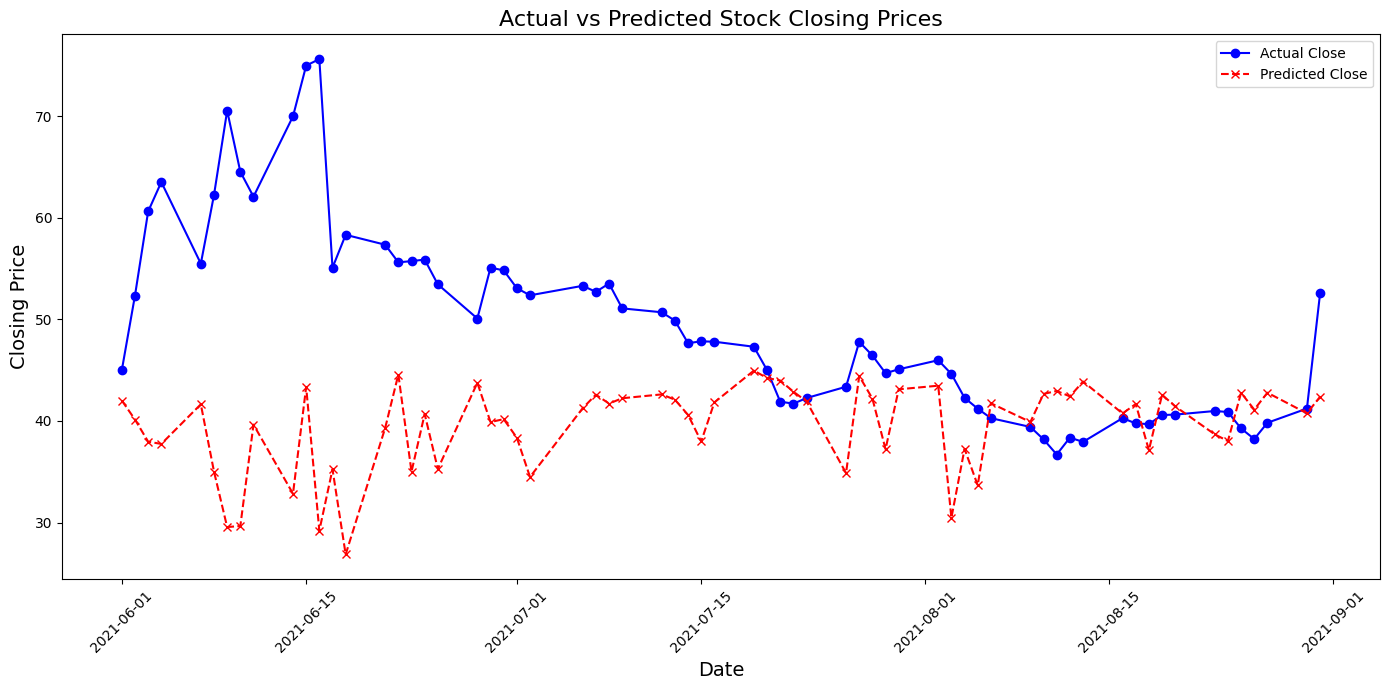

In [70]:
import matplotlib.pyplot as plt

# Ensure the 'Date' column is in datetime format for proper plotting
predictions_with_actuals_df['Date'] = pd.to_datetime(predictions_with_actuals_df['Date'])

# Setting the plot size for better readability
plt.figure(figsize=(14, 7))

# Plotting the actual closing prices
plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Actual_Close'], label='Actual Close', color='blue', marker='o')

# Plotting the predicted closing prices
plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Predicted_Close'], label='Predicted Close', color='red', linestyle='--', marker='x')

# Adding title and labels with font size adjustments
plt.title('Actual vs Predicted Stock Closing Prices', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)

# Rotating date labels for better visibility
plt.xticks(rotation=45)

# Adding a legend to distinguish between actual and predicted values
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

## After introducing a spike in the data

In [71]:
df_spiked = pd.read_csv("GME_spiked.csv")

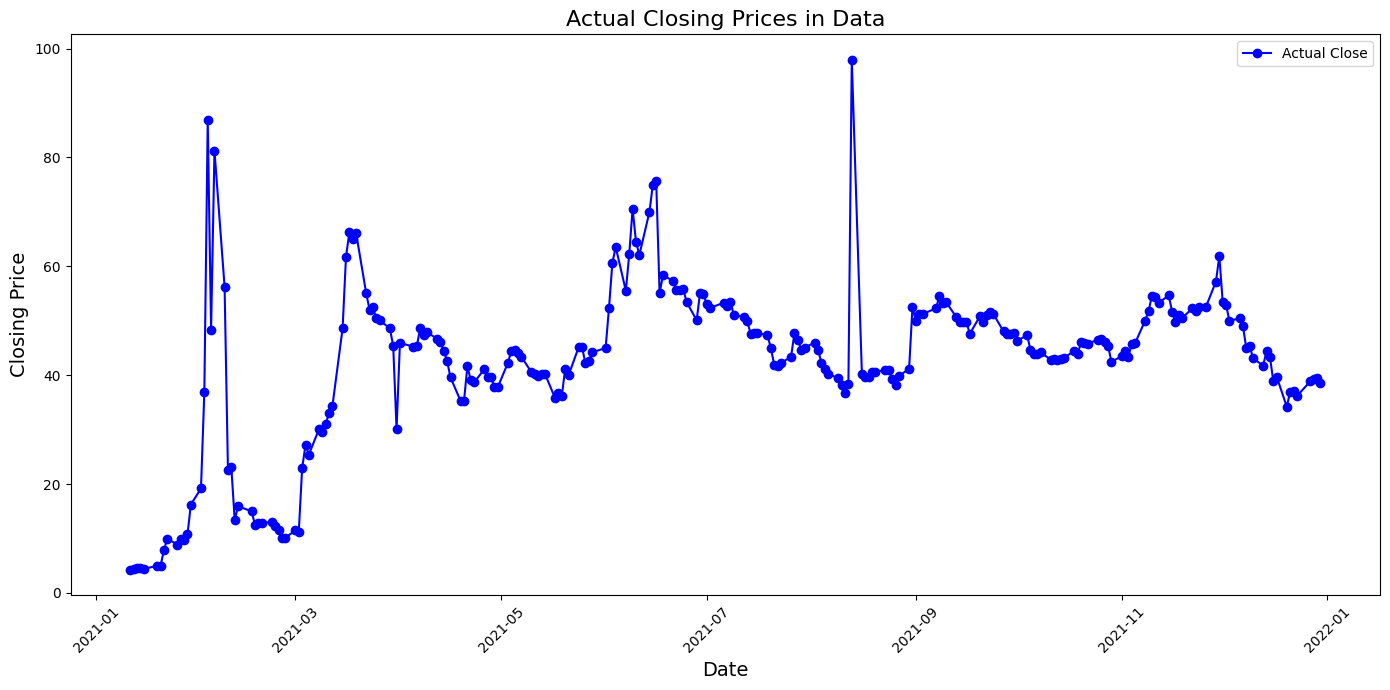

In [72]:
# Ensure the 'Date' column is in datetime format for proper plotting
df_spiked['Date'] = pd.to_datetime(df['Date'])

# Setting the plot size for better readability
plt.figure(figsize=(14, 7))

# Plotting the actual closing prices in the training period
plt.plot(df_spiked['Date'], df_spiked['Close'], label='Actual Close', color='blue', marker='o')

# Adding title and labels with font size adjustments
plt.title('Actual Closing Prices in Data', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)

# Rotating date labels for better visibility
plt.xticks(rotation=45)

# Adding a legend to distinguish the actual values
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [73]:
# Convert 'Date' to datetime and sort the DataFrame just in case
df_spiked['Date'] = pd.to_datetime(df_spiked['Date']) # This line converts the 'Date' column of the DataFrame df to datetime objects.
df_spiked.sort_values('Date', inplace=True)
#  The .values attribute returns the data as a NumPy array. The .reshape(-1, 1) function changes
#  the shape of this array to ensure it has two dimensions, with one column and as many rows as necessary.
close_prices = df_spiked['Close'].values.reshape(-1, 1)
# Scale the data -> you can use any appropriate scaling methodology
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close_prices = scaler.fit_transform(close_prices)

In [74]:
combined_df = pd.merge(df_spiked, df_sentiment, left_on='Date', right_on='date', how='left')
combined_df.drop(columns=['date'], inplace=True) # Drop the duplicate 'date' column
combined_df.fillna(method='ffill', inplace=True) # Forward fill any missing values

In [75]:
combined_df.dropna(inplace=True)
combined_df.reset_index(drop=True, inplace=True)
combined_df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)

combined_df['Closing Price'] = combined_df['Close']
combined_df.drop(columns=['Close'], inplace=True)

In [76]:
combined_df.head(20)

,Date,num_comments,score,avg_weighted_compound,avg_weighted_neg,avg_weighted_neu,avg_weighted_pos,Closing Price
0,2021-01-11,20.0,1.0,0.000000,0.000000,1.000000,0.000000,4.312500
1,2021-01-12,20.0,1.0,0.000000,0.000000,1.000000,0.000000,4.342500
2,2021-01-13,21.0,3.0,0.000000,0.000000,1.000000,0.000000,4.590000
3,2021-01-14,29.0,1.0,0.000000,0.000000,1.000000,0.000000,4.520000
4,2021-01-15,29.0,1.0,0.000000,0.000000,1.000000,0.000000,4.422500
5,2021-01-19,41.0,3.0,0.067768,0.122415,0.712220,0.165366,4.985000
6,2021-01-20,154.0,2.0,0.381643,0.000000,0.603429,0.396571,4.987500
7,2021-01-21,320.0,5.0,0.019982,0.072337,0.903703,0.023831,7.850000
8,2021-01-22,1002.0,11.0,0.046663,0.000000,0.957446,0.042554,9.977500
9,2021-01-25,23.0,1.0,0.000000,0.000000,1.000000,0.000000,8.875000


In [77]:
print(combined_df.shape)

print(combined_df.info())

(251, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   251 non-null    datetime64[ns]
 1   num_comments           251 non-null    float64       
 2   score                  251 non-null    float64       
 3   avg_weighted_compound  251 non-null    float64       
 4   avg_weighted_neg       251 non-null    float64       
 5   avg_weighted_neu       251 non-null    float64       
 6   avg_weighted_pos       251 non-null    float64       
 7   Closing Price          251 non-null    float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 15.8 KB
None


In [78]:
combined_df['Date'] = pd.to_datetime(combined_df['Date'])

In [79]:
train_indices = combined_df[combined_df["Date"] <= TRAIN_END_DATE].index
test_indices = combined_df[(combined_df["Date"] > TRAIN_END_DATE) & (combined_df["Date"] <= TEST_END_DATE)].index

combined_train_df = combined_df[combined_df.index <= pd.to_datetime(TRAIN_END_DATE)]
combined_test_df = combined_df[(combined_df.index > pd.to_datetime(TRAIN_END_DATE)) & (combined_df.index <= pd.to_datetime(TEST_END_DATE))]

In [80]:
features = combined_df.drop(columns=['Date']) # Drop the 'Date' column
target = combined_df['Closing Price'] # Set the 'Closing Price' as the target variable

In [81]:
scaler_new = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_new.fit_transform(features)
scaled_target = scaler_new.fit_transform(target.values.reshape(-1, 1)).flatten()  # Flatten to make it a 1D array

In [82]:
def create_train_sequences(features, target, sequence_length):
    X, y = [], []
    for i in range(len(features) - sequence_length):
        seq = features[i:i+sequence_length]  # Include closing price in features
        X.append(seq)
        y.append(target[i + sequence_length])  # Target is the closing price at sequence_length ahead
    return np.array(X), np.array(y)

In [83]:
def create_test_sequences(features, target, sequence_length):
    X, y = [], []
    for i in range(len(features) - sequence_length):
        seq = features[i:i+sequence_length, :-1]  # Exclude closing price from features
        X.append(seq)
        y.append(target[i + sequence_length])  # Target is still the closing price
    return np.array(X), np.array(y)

In [84]:
# Splitting the data
train_end = train_indices[-1] + 1  
test_end = test_indices[-1] + 1

# Creating training sequences
X_train, y_train = create_train_sequences(scaled_features[:train_end], scaled_target[:train_end], SEQUENCE_LENGTH)

# Creating testing sequences
# For X_test, we want to exclude the closing price
X_test, y_test = create_train_sequences(scaled_features[train_end:test_end], scaled_target[train_end:test_end], SEQUENCE_LENGTH)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [85]:
X_train.shape, y_train.shape

((87, 10, 7), (87, 1))

In [86]:
X_test.shape, y_test.shape

((55, 10, 7), (55, 1))

In [87]:
# Initialize the starting sequence for prediction
current_sequence = X_train[-1]

# Initialize an empty list to store predicted prices
predicted_prices = []

# Predict future prices
for i in range(len(business_days)):
    
    if i < len(X_test):
        current_sequence = X_test[i]
    else:
        # Prepare the next sequence based on the last prediction
        next_sequence = np.roll(current_sequence, -1, axis=0)
        next_sequence[-1, -1] = predicted_close_scaled.flatten()[0] 
        current_sequence = next_sequence

    # Reshape the current sequence to match the model's expected input shape and predict the next closing price
    predicted_close_scaled = lstm_model.predict(current_sequence.reshape(1, SEQUENCE_LENGTH, current_sequence.shape[1]))

    # Store the scaled prediction
    predicted_prices.append(predicted_close_scaled.flatten()[0])

# Inverse transform the scaled predicted prices to their original scale
predicted_prices = scaler_new.inverse_transform(np.array(predicted_prices).reshape(-1, 1)).flatten()

# Create a DataFrame with the predicted stock prices and corresponding dates
predictions_df = pd.DataFrame({
    'Date': business_days,
    'Predicted_Close': predicted_prices
})

# Display the prediction results
print(predictions_df)

1/1 [==============================] - 0s 62ms/step
         Date  Predicted_Close
0  2021-06-01        47.354233
1  2021-06-02        47.763813
2  2021-06-03        46.136074
3  2021-06-04        44.962330
4  2021-06-07        48.447960
..        ...              ...
61 2021-08-25        47.174320
62 2021-08-26        42.558910
63 2021-08-27        47.503368
64 2021-08-30        45.167538
65 2021-08-31        46.504169

[66 rows x 2 columns]


In [88]:
# Continue from the previous predictions_df creation code

# Ensure the 'Date' columns in both DataFrames are in the same format
df_spiked['Date'] = pd.to_datetime(combined_df['Date'])
predictions_df['Date'] = pd.to_datetime(predictions_df['Date'])

# Merge the predictions with the actual closing prices from 'df'
predictions_with_actuals_df = predictions_df.merge(df_spiked[['Date', 'Close']], on='Date', how='left')

# Rename columns for clarity
predictions_with_actuals_df.rename(columns={'Close': 'Actual_Close'}, inplace=True)

# Show the DataFrame with predictions and actual closing prices
print(predictions_with_actuals_df)

         Date  Predicted_Close  Actual_Close
0  2021-06-01        47.354233     45.002499
1  2021-06-02        47.763813     52.357498
2  2021-06-03        46.136074     60.639999
3  2021-06-04        44.962330     63.532501
4  2021-06-07        48.447960     55.500000
..        ...              ...           ...
61 2021-08-25        47.174320     39.262501
62 2021-08-26        42.558910     38.224998
63 2021-08-27        47.503368     39.825001
64 2021-08-30        45.167538     41.222500
65 2021-08-31        46.504169     52.572498

[66 rows x 3 columns]


In [89]:
print(predictions_with_actuals_df["Actual_Close"].isnull().sum())
print(predictions_with_actuals_df["Predicted_Close"].isnull().sum())

predictions_with_actuals_df.dropna(subset=["Actual_Close", "Predicted_Close"], inplace=True)

1
0


In [90]:
mse = mean_squared_error(predictions_with_actuals_df["Actual_Close"], predictions_with_actuals_df["Predicted_Close"])
rmse = np.sqrt(mse)
mae = mean_absolute_error(predictions_with_actuals_df["Actual_Close"], predictions_with_actuals_df["Predicted_Close"])

print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ", rmse)
print("Mean Absolute Error: ", mae)

Mean Squared Error:  210.95748559607551
Root Mean Squared Error:  14.52437556647705
Mean Absolute Error:  9.785541507972132


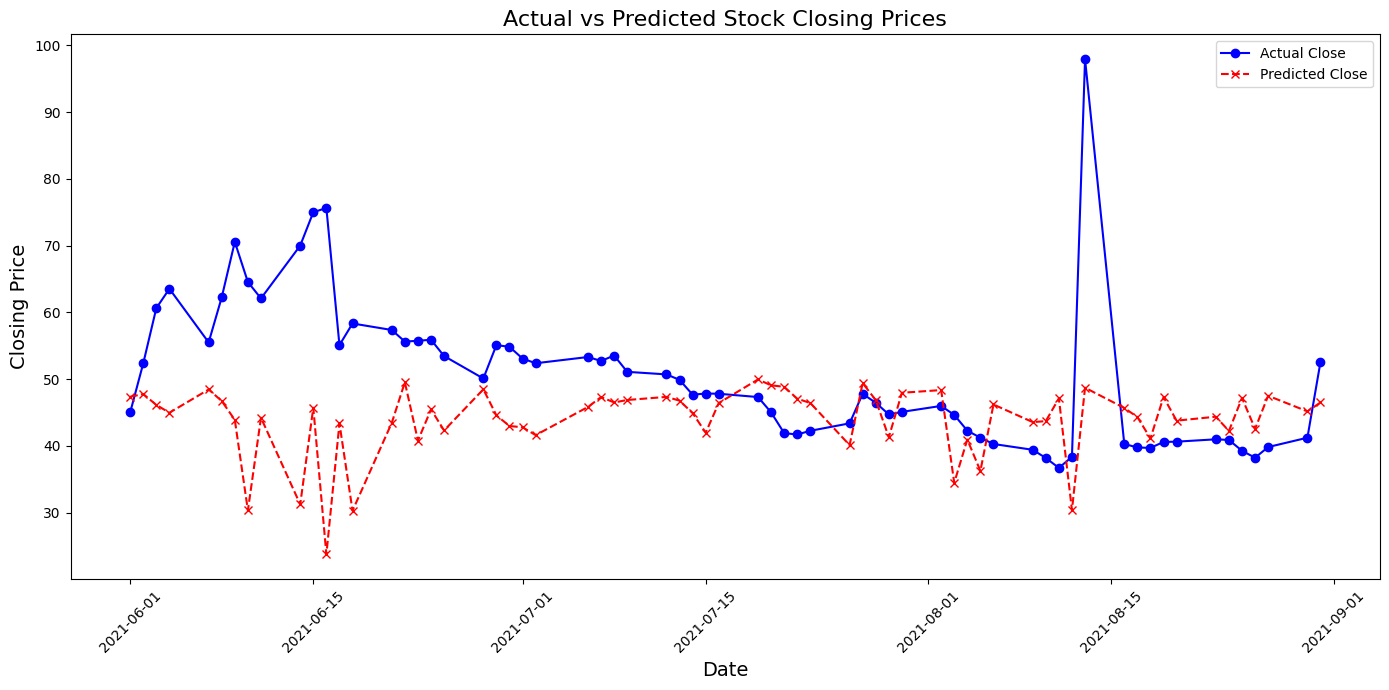

In [91]:


# Ensure the 'Date' column is in datetime format for proper plotting
predictions_with_actuals_df['Date'] = pd.to_datetime(predictions_with_actuals_df['Date'])

# Setting the plot size for better readability
plt.figure(figsize=(14, 7))

# Plotting the actual closing prices
plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Actual_Close'], label='Actual Close', color='blue', marker='o')

# Plotting the predicted closing prices
plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Predicted_Close'], label='Predicted Close', color='red', linestyle='--', marker='x')

# Adding title and labels with font size adjustments
plt.title('Actual vs Predicted Stock Closing Prices', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)

# Rotating date labels for better visibility
plt.xticks(rotation=45)

# Adding a legend to distinguish between actual and predicted values
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()